# __Estimating rock mass effective properties from a DFN approach__

### Problem statement


Rock mass mechanical properties are strongly controlled by the fractures they contain.
<br>
To compensate the impossibility to perform direct in-situ measures of these properties at appropriate scales, empirical approaches classically aim to determine the rock mass equivalent properties from simple indicators. Here we propose an approach based on the complete representation of the rock mass as an intact rock with a population of discrete fractures through it.


<center>
<img src="img/rmtool.png" width=700>
<br>
Estimation of a full effective compliance tensor from a DFN model
</center>

### Theoretical background

The core of the approach is the definition, at the rock mass scale, of the deformation induced by each fracture locally, including the fracture mechanical and geometrical parameters, the remote stress conditions and the interactions with the rest of the fracture population [(Davy et. 2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017JB015329).

### What will you learn ?

- Compute mechanical effective properties of a rock mass containing a DFN

### DFN.Lab model


The required module is __RockMassTool__.

In [1]:
import dfnlab.RockMassTool as rmtool

_________

### Estimating effective mechanical properties from a DFN approach

First, we initialize the system, made of a cubic domain and import a DFN from disk file.

In [2]:
import dfnlab.System as sys 
import dfnlab.Domains as dom 
import dfnlab.Fractures as dfn
import dfnlab.IO as io
import os 

system = sys.System()
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=1.)
system.setDomain(domain)
fnet = dfn.DFN()
system.setDFN(fnet)
io.load_DFN_file(fnet, 'sources/Ktest.disk', format="disk") 
system.build()

Then, you need to create a _RockMassTool_ object from the system, and eventually a remote stress field.

In [3]:
import numpy as np
import dfnlab.Mechanics as mech
sigma = np.array([[-1e4,0.,0.],[0.,-1e4,0.],[0.,0.,-3e7]])
remoteStress = mech.Stress(sigma)

rmt = rmtool.RockMassTool(system,remoteStress)

Rock matrix elastic mechanical properties need to be assigned

In [4]:
rmt.addProperties("young", 53e9)
rmt.addProperties("poisson", 0.25)

And, fracture mechanical properties (Mohr-Coulomb model).
<br>
It can be either constant or depend on the applied normal stress (normal and shear stiffness).

In [5]:
mech.ShearStiffness.setConstant(system.getDFN(),0)
mech.NormalStiffness.setConstant(system.getDFN(),float("inf"))
mech.Tension.setConstant(system.getDFN(),0)
mech.Cohesion.setConstant(system.getDFN(),0.)
mech.Friction.setConstant(system.getDFN(),30.)
mech.DilationAngle.setConstant(system.getDFN(),0.)
mech.MaximumDilationShearDisplacement.setConstant(system.getDFN(),-1.)

Finally, we can compute the full effective compliance tensor (matrix 6x6)

In [6]:
C = rmt.computeEffectiveComplianceTensor()

You can obtain the mean effective young modulus and mean Poisson ratio as follow:

In [7]:
Ex=1/C[0,0]
Ey=1/C[1,1]
Ez=1/C[2,2]
Eeff = (Ex+Ey+Ez)/3.
print("Effective Young modulus: {}".format(Eeff))

Effective Young modulus: 38131816461.3989


________

### Example 1: Evolution of effective Young modulus with percolation parameter

In this example, we will generate several DFNs with increasing density, to study the evolution of effective Young modulus $E$ with percolation parameter. We only consider freely-slipping fractrues here ($k_s=0$).

First, we define a function to create a DFN system of given percolation parameter.
<br>
The system size is $L=100$, fracture size is constant $l_f=10$, fracture orientation and positions distribution are uniform.

In [8]:
import dfnlab.Fractures as dfn
import dfnlab.Domains as dom
import dfnlab.System as sys
import dfnlab.Generator as gen

def create_dfn_from_percolation_parameter(perco,seed=1001):
    system = sys.System()
    domain = dom.Domain()
    domain.buildParallelepiped(center=[0, 0, 0], L1=100)
    system.setDomain(domain)
    fnet = dfn.DFN()
    system.setDFN(fnet)
    pgenerator = gen.Generator(system, seed)
    pgenerator.setSizesUniform(lmin=10,lmax=10)
    pgenerator.setPositionsUniform()
    pgenerator.setOrientationsUniform()
    pgenerator.setStopPercolation(perco)
    pgenerator.generate()
    system.build()
    return system

Secondly, we define a function that compute the full effective mechanical compliance tensor for freely slipping fractures ($k_s=0$).

In [9]:
import dfnlab.Mechanics as mech
import numpy as np
import math

def compute_effective_compliance_tensor_freely_slipping(system,E,nu):
    sigma = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,-1e6]])
    remoteStress = mech.Stress(sigma)
    rmt = rmtool.RockMassTool(system,remoteStress)
    # add matrix mechanical properties
    rmt.addProperties("young", E)
    rmt.addProperties("poisson", nu)
    # add fracture mechanical proporties
    mech.ShearStiffness.setConstant(system.getDFN(),0)
    mech.NormalStiffness.setConstant(system.getDFN(),float("inf"))
    mech.Tension.setConstant(system.getDFN(),0)
    mech.Cohesion.setConstant(system.getDFN(),0.)
    mech.Friction.setConstant(system.getDFN(),30.)
    mech.DilationAngle.setConstant(system.getDFN(),0.)
    mech.MaximumDilationShearDisplacement.setConstant(system.getDFN(),-1.)
    # compute effective compliance tensor
    C = rmt.computeEffectiveComplianceTensor()
    return C

We will now generate different DFNs of percolation $p \in [0,0.5,1,2,3,5,7.5,10,15,20]$.

In [10]:
pList = [0,0.5,1,2,3,5,7.5,10,15,20]
E0=53e9
nu=0.25
EeffList = []
for p in pList:
    if p==0:
        EeffList.append(E0)
        continue
    unif = create_dfn_from_percolation_parameter(perco=p)
    C = compute_effective_compliance_tensor_freely_slipping(unif,E=E0,nu=nu)   
    Ex = 1./C[0,0]
    Ey = 1./C[1,1]
    Ez = 1./C[2,2]
    Eeff = (Ex+Ey+Ez)/3.
    EeffList.append(Eeff)

And plot the evolution of effective Young modulus $E_{eff}$ with percolation parameter $p$. The results are in good agreement with the theoretical development presented in  [(Davy et. 2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017JB015329).

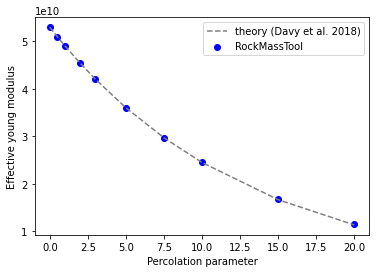

In [11]:
import matplotlib.pyplot as pyplot
fig = pyplot.figure()
ax = pyplot.axes()
pyplot.xlabel('Percolation parameter')
pyplot.ylabel('Effective young modulus') 
ax.scatter(pList,EeffList,marker='o',color='blue',label="RockMassTool")
theo = [E0*math.exp(-0.91*2/math.pi*0.13333*x) for x in pList]
pyplot.plot(pList,theo,linestyle='--',color='grey',label="theory (Davy et al. 2018)")
pyplot.legend()
pyplot.show()

________

### Example 2: Application on Forsmark FFM01 fracture domain

In this example, we proceed to the same kind of analysis with an application on Forsmark FFM01 fracture domain, as in ([Darcel et al. 2018](https://onepetro.org/ARMADFNE/proceedings-abstract/DFNE18/3-DFNE18/D033S016R002/122815)).

We first define a function to create a FFM01 DFN of given domain size $L$.

In [12]:
def create_ffm01(L):
    # parameters
    ag=3
    au=4
    lmin=0.1
    lc=3.3
    lmax=L #20
    family_dict = { "family_ns": {"plunge":1, "trend":292,"kappa":17.8,"p32":1.292}, \
                "family_ne": {"plunge":2, "trend":326,"kappa":14.3,"p32":1.733}, \
                "family_nw": {"plunge":6, "trend":60,"kappa":12.9,"p32":0.948}, \
                "family_ew": {"plunge":2, "trend":15,"kappa":14.0,"p32":0.169}, \
                "family_hz": {"plunge":86,"trend":5,"kappa":15.2,"p32":0.624}  \
    }    
    # init system
    system = sys.System()
    domain = dom.Domain()
    system.setDomain(domain)
    domain.buildParallelepiped(center=[0, 0, 0], L1=L)
    fnet = dfn.DFN()
    system.setDFN(fnet)    
    # init generator
    generator = gen.Generator(system,seed=1001)
    domainProp = gen.Properties()
    domain.addProperties("generation", domainProp) 
    # define family properties
    for family_name, family_params in family_dict.items():
        family = gen.Statistics()
        if lmax<=lc:
            family.setSizesPowerlaw(a=ag,lmin=lmin,lmax=lmax)
        else:
            family.setSizesDoublePowerlaw(a1=ag,a2=au,lmin=lmin,lc=lc,lmax=lmax)
        dip = 90. - family_params["plunge"]
        dipd = (family_params["trend"]-180) if family_params["trend"]>180 else (family_params["trend"]+180)
        family.setOrientationsFisher(dip=dip, dipd=dipd, kappa= family_params["kappa"]) 
        family.setPositionsUniform()
        family.setStopDensity(family_params["p32"])
        domainProp.add(family, family_name)        
    # generate dfn
    generator.generate()
    system.build()
    return system

Remote stress conditions at the Forsmark site are used to compute rock mass effective properties, using a stress dependent relationship for $k_s$ and $k_n$:

$k_s=46.55.\sigma_n^{0.4039} kPa$

$k_n=2.28 . \sigma_n^{0.822} kPa$

Friction angle and cohesion are set to $37°$ and $1kPa$ respectively.

In [13]:
import dfnlab.Mechanics as mech
import numpy as np
import math

def compute_effective_compliance_tensor_from_stress(system,remoteStress,E,nu,coh,fric):
    rmt = rmtool.RockMassTool(system,remoteStress)
    rmt.addProperties("young", E)
    rmt.addProperties("poisson", nu)
    mech.NormalStiffness.setNormalStressPowerlaw(system.getDFN(), a=2.28e6, b=0.822, std=0.)
    mech.ShearStiffness.setNormalStressPowerlaw(system.getDFN(), a=46.55e6, b=0.4039, std=0.)
    mech.Tension.setConstant(system.getDFN(),0)
    mech.Cohesion.setConstant(system.getDFN(),coh)
    mech.Friction.setConstant(system.getDFN(),fric)
    mech.DilationAngle.setConstant(system.getDFN(),0.)
    mech.MaximumDilationShearDisplacement.setConstant(system.getDFN(),-1.)
    C = rmt.computeEffectiveComplianceTensor()
    return C

We compute the evolution of effective Young modulus with domain size $L$, considering both freely slipping fractures and stress-dependent joints stiffnesses.

In [14]:
import dfnlab.Analysis as an

E0=76e9
nu=0.25
coh=1e6
fric=37
tens=0
remoteStress = mech.Stress(s1=-23.9e6, trend1=145, plunge1=0, s2=-13.6e6, trend2=55, plunge2=0, s3=-5.3e6, trend3=0, plunge3=90)

LList = [0.5,1,2,5,7,10,15,20]
EeffList_1 = []
EeffList_2 = []
pList=[]
for L in LList:
    if L==0:
        EeffList_1.append(E0)
        EeffList_2.append(E0)
        pList.append(0.)
        continue
    ffm01 = create_ffm01(L)
    analyser = an.Analyser(ffm01)
    pList.append(analyser.percolation())
    C = compute_effective_compliance_tensor_freely_slipping(ffm01, E0, nu)
    Ex = 1./C[0,0]
    Ey = 1./C[1,1]
    Ez = 1./C[2,2]
    Eeff = (Ex+Ey+Ez)/3.
    EeffList_1.append(Eeff)
    C = compute_effective_compliance_tensor_from_stress(ffm01,remoteStress,E0,nu,coh,fric)
    Ex = 1./C[0,0]
    Ey = 1./C[1,1]
    Ez = 1./C[2,2]
    Eeff = (Ex+Ey+Ez)/3.
    EeffList_2.append(Eeff)

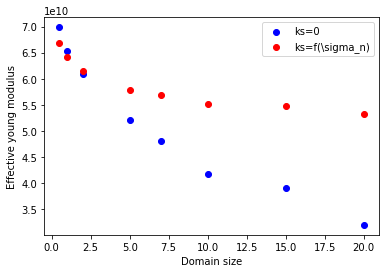

In [15]:
import matplotlib.pyplot as pyplot
fig = pyplot.figure()
ax = pyplot.axes()
pyplot.xlabel('Domain size')
pyplot.ylabel('Effective young modulus') 
ax.scatter(LList,EeffList_1,marker='o',color='blue',label="ks=0")
ax.scatter(LList,EeffList_2,marker='o',color='red',label="ks=f(\sigma_n)")
pyplot.legend()
pyplot.show()